# **Telecom Churn Analytics:** 
## ***Building Predictive Models to Improve Customer Retention***

### Section 4: Predictive Model 🤖📚

---

### Objective
* The aim of this model is to predict customer churn rate by leveraging both demographic attributes (e.g., age, dependency, tenure) and subscription-related attributes (e.g., plan type, billing method, service usage, contract length). 

* The model enables the telecom company to 

     - Estimate churn rate more accurately across different customer segments.

     - Identify key churn drivers, such as high call drop rates, short contract terms, or specific demographic patterns.

     - Enhance retention strategies by targeting at-risk customers with personalized offers, loyalty programs, or improved service quality.

     - Optimize marketing campaigns by focusing resources on customers most likely to churn, thereby reducing acquisition costs and improving lifetime value.

### Input
* A cleaned and processed dataset with *onehot-encoded* catetegorical and *scaled* numeric variables. 

     * **Features:** 
     gender, 
     SeniorCitizen, 
     Partner, 
     Dependents, 
     tenure, 
     PhoneService, 
     MultipleLine, 
     InternetService,
     OnlineSecurity,
     OnlineBackup,
     DeviceProtection,
     TechSupport,
     StreamingTV,
     StreamingMovies,
     Contract,
     PaperlessBilling,
     PaymentMethod,
     MonthlyCharges, 
     TotalCharges, 
     CustomerType           

     * **Target:** 
     Churn

### Training Procedures

1. Train Base Model with GridSearchCV

     * Begin with baseline models (e.g., Logistic Regression, Decision Tree) to establish a performance benchmark.

     * Valuate using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

2. Select High-Performance Models

     * Compare models based on performance metrics and interpretability.

     * Shortlist models that demonstrate strong generalization and balanced recall–precision trade-off

3. Tune the Selected Models (Hyperparameter Optimization)

     * Apply GridSearchCV further to optimize hyperparameters for the shortlisted models.

     * Improve performance and reduce overfitting by finding the best parameter configuration.

4. Feature Importance and Model Refinement

     * Identify top contributing features using feature importance or model coefficients.

     * Retrain the tuned model using the most impactful features to enhance interpretability and efficiency.


### Output
 * A high performance ML model with features below which to be used for the churn estimator in the dashboard.
 
     * A summary table comparing models (accuracy, recall, precision, ROC-AUC)

     * The best model selected automatically

     * Optimized hyperparameters after tuning

     * A feature importance plot for the best model

     * Final retraining with only top features


---

### Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory
We need to change the working directory from its current folder to its parent folder

In [1]:
import os

os.chdir(os.path.dirname(os.getcwd()))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: /Users/denniskwok/Documents/data-analytics/telecom-churn-ml-prediction


---

### ML Model: Predict Customer Churn Based on Demographic and Subscription patterns

Load the encoded dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

df_encoded = pd.read_csv("dataset/processed/telecom_customer_churn_encoded.csv")


Split features and target for train-test

In [3]:
from sklearn.model_selection import train_test_split

# Split into features and target
X = df_encoded.drop(["Churn_Yes"], axis=1)
y = df_encoded["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (5634, 26) (5634,) 
* Test set: (1409, 26) (1409,)


📘 **Model Rationale**

Telecom churn data typically exhibits complex, non-linear interactions among categorical features — for example, between internet add-ons, contract length, and payment method. These interdependencies mean that the relationships between predictors and churn outcomes are not purely linear.

While Logistic Regression performs well for datasets with linear feature relationships, tree-based models capture complex, non-linear interactions among variables with strong prediction capability.

The project will train both models independently and compare their performance (accuracy, recall, ROC-AUC) leading to more robust and accurate churn predictions.

In [4]:
# Import models and evaluation metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report)

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            # If you want to add preprocessing steps, modify the pipeline here.
            model = Pipeline([('model', self.models[key])])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs    
            # No pipeline optimization needed, so leave this section empty or add a pass statement
            pass  
          
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches
    
    def performance_metrics(self, X_test, y_test, sort_by='ROC-AUC'):
        results = []

        for model_name, gs in self.grid_searches.items():
            best_model = gs.best_estimator_
            y_pred = best_model.predict(X_test)
            y_prob = best_model.predict_proba(X_test)[:, 1]

            results.append({
                "Model": model_name,
                "Best Params": gs.best_params_,
                "CV_Accuracy": round(gs.best_score_, 3),  # Cross-validation accuracy (same as score_summary)
                "Test_Accuracy": round(accuracy_score(y_test, y_pred), 3),  # Test set accuracy
                "Test_Precision": round(precision_score(y_test, y_pred), 3),
                "Test_Recall": round(recall_score(y_test, y_pred), 3),
                "Test_F1": round(f1_score(y_test, y_pred), 3),
                "Test_ROC-AUC": round(roc_auc_score(y_test, y_prob), 3)
            })

        results_df = pd.DataFrame(results).sort_values(by="CV_Accuracy", ascending=False).reset_index(drop=True)
        return results_df.style.highlight_max(axis=0, subset=['CV_Accuracy', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC-AUC'], color="green")


Define a list of models and their respective hyperparameters

In [5]:
models_search = {
    "LogisticRegression": LogisticRegression(random_state=89),
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=89),
    "RandomForestClassifier":RandomForestClassifier(random_state=89),
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=89),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=89),
    "AdaBoostClassifier":AdaBoostClassifier(random_state=89),
}

Hyperparameter optimisation search using the default hyperparameters values

In [6]:
params_search = {
    "LogisticRegression":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}


Fit training pipeline with GridSearchCV

In [7]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)



Running GridSearchCV for LogisticRegression 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


DataFrame with all the training results summary and a dictionary containing all pipelines

In [8]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

grid_search_summary.style.highlight_max(axis=0, subset=['min_score', 'mean_score', 'max_score', 'std_score'], color="green")

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.798722,0.799255,0.799787,0.000532
5,AdaBoostClassifier,0.793752,0.798012,0.802272,0.004260
3,GradientBoostingClassifier,0.791622,0.794107,0.796592,0.002485
2,RandomForestClassifier,0.791977,0.792332,0.792687,0.000355
4,ExtraTreesClassifier,0.772098,0.775648,0.779198,0.003550
1,DecisionTreeClassifier,0.731629,0.736777,0.741924,0.005147


In the baseline training, LogisticRegression performed the best score for Accuracy. Let's look into the performance metrics in details.

In [9]:
grid_metrics = search.performance_metrics(X_test, y_test, sort_by='CV_Accuracy')
grid_metrics

,Model,Best Params,CV_Accuracy,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC-AUC
0,LogisticRegression,{},0.799000,0.818000,0.690000,0.537000,0.604000,0.850000
1,AdaBoostClassifier,{},0.798000,0.811000,0.684000,0.504000,0.580000,0.853000
2,GradientBoostingClassifier,{},0.794000,0.811000,0.686000,0.496000,0.576000,0.852000
3,RandomForestClassifier,{},0.792000,0.796000,0.650000,0.463000,0.541000,0.831000
4,ExtraTreesClassifier,{},0.776000,0.771000,0.573000,0.452000,0.505000,0.807000
5,DecisionTreeClassifier,{},0.737000,0.715000,0.451000,0.466000,0.458000,0.633000


/var/folders/qx/sssvngh16h16kvg986485h1r0000gn/T/ipykernel_27397/2601463427.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/denniskwok/Documents/data-analytics/telecom-churn-ml-prediction/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


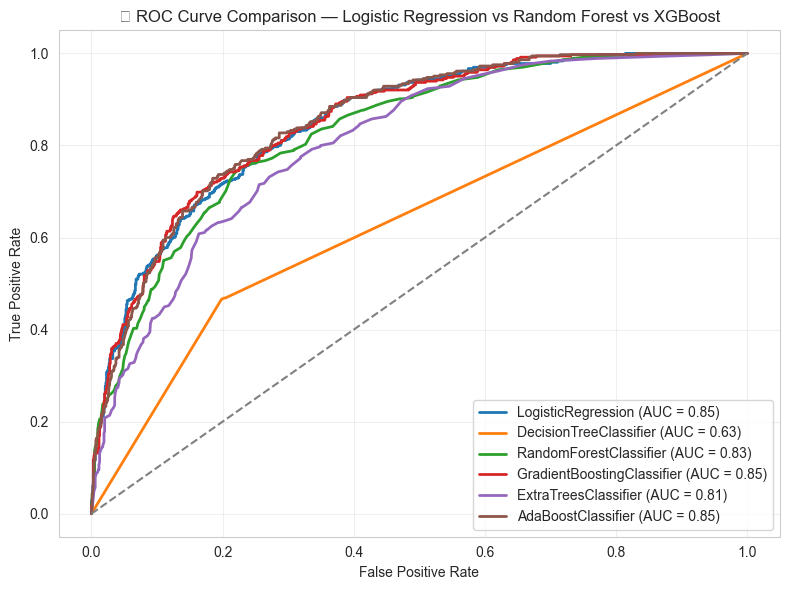

In [10]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models_search.items():
    pipe = Pipeline(steps=[("model", model)])
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.title("📈 ROC Curve Comparison — Logistic Regression vs Random Forest vs XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Train Advanced Model

**Focusing on three models for further hyperparameter tuning**

In [11]:
models_search = {
    "AdaBoostClassifier":AdaBoostClassifier(random_state=89),
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=89),
    "LogisticRegression":LogisticRegression(max_iter=1000, random_state=89),
}

params_search = {
    "AdaBoostClassifier": {"model__n_estimators": [20, 50]},
    "GradientBoostingClassifier": {"model__n_estimators": [40, 20]},
    "LogisticRegression": {"model__C": [0.1, 1.0, 10.0]}
}


In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)


Running GridSearchCV for AdaBoostClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits

Running GridSearchCV for LogisticRegression 

Fitting 2 folds for each of 3 candidates, totalling 6 fits


**Advanced Model Accuracy Summary**

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.style.highlight_max(axis=0, subset=['min_score', 'mean_score', 'max_score', 'std_score'], color="green")

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators,model__C
5,LogisticRegression,0.798722,0.799255,0.799787,0.000532,nan,1.000000
4,LogisticRegression,0.796947,0.798545,0.800142,0.001597,nan,0.100000
1,AdaBoostClassifier,0.793752,0.798012,0.802272,0.004260,50,nan
6,LogisticRegression,0.795527,0.797125,0.798722,0.001597,nan,10.000000
2,GradientBoostingClassifier,0.793397,0.795705,0.798012,0.002307,40,nan
3,GradientBoostingClassifier,0.791267,0.793397,0.795527,0.002130,20,nan
0,AdaBoostClassifier,0.788427,0.793397,0.798367,0.004970,20,nan


### Second Round Training with tuned hyperparameters

In [14]:
# Focusing on three models for further hyperparameter tuning
models_search = {
    "AdaBoostClassifier":AdaBoostClassifier(random_state=89),
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=89),
    "LogisticRegression":LogisticRegression(max_iter=1000, random_state=89),
}

params_search = {
    "AdaBoostClassifier": {"model__n_estimators": [50, 70]},
    "GradientBoostingClassifier": {"model__n_estimators": [40, 70]},
    "LogisticRegression": {"model__C": [0.1, 1.0, 2.0]}
}


In [15]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)


Running GridSearchCV for AdaBoostClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits

Running GridSearchCV for LogisticRegression 

Fitting 2 folds for each of 3 candidates, totalling 6 fits


**Advanced Models Accuracy Summary**

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

grid_search_summary.style.highlight_max(axis=0, subset=['min_score', 'mean_score', 'max_score', 'std_score'], color="green")

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators,model__C
5,LogisticRegression,0.798722,0.799255,0.799787,0.000532,nan,1.000000
6,LogisticRegression,0.798367,0.798722,0.799077,0.000355,nan,2.000000
4,LogisticRegression,0.796947,0.798545,0.800142,0.001597,nan,0.100000
0,AdaBoostClassifier,0.793752,0.798012,0.802272,0.004260,50,nan
3,GradientBoostingClassifier,0.794817,0.796415,0.798012,0.001597,70,nan
2,GradientBoostingClassifier,0.793397,0.795705,0.798012,0.002307,40,nan
1,AdaBoostClassifier,0.794817,0.795527,0.796237,0.000710,70,nan


**Performance Metrics Models with Best Hyperparameters Tuning**

In [17]:
grid_metrics = search.performance_metrics(X_test, y_test, sort_by='CV_Accuracy')
grid_metrics

,Model,Best Params,CV_Accuracy,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC-AUC
0,LogisticRegression,{'model__C': 1.0},0.799000,0.818000,0.690000,0.537000,0.604000,0.850000
1,AdaBoostClassifier,{'model__n_estimators': 50},0.798000,0.811000,0.684000,0.504000,0.580000,0.853000
2,GradientBoostingClassifier,{'model__n_estimators': 70},0.796000,0.812000,0.691000,0.496000,0.577000,0.851000


**Best performance model**

In [18]:
best_model = grid_search_summary.iloc[0,0]
best_model

'LogisticRegression'

In [19]:
grid_search_pipelines[best_model].best_params_

{'model__C': 1.0}

In [20]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('model', LogisticRegression(max_iter=1000, random_state=89))])

**Confusion Matrix: Detailed performance breakdown for train/test sets**

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline, label_map):
  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  # Ensure label_map is string type for concatenation
  label_map_str = [str(sub) for sub in label_map]
  print(pd.DataFrame(confusion_matrix(y, prediction),
    columns=[ "Prediction " + sub for sub in label_map_str ],
    index=[ "Actual " + sub for sub in label_map_str ]
    ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test, y_test, pipeline, label_map)
  
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map= df_encoded['Churn_Yes'].unique() 
                # In this case, the target variable is encoded as categories and we
                # get the values with .unique()
                )

#### Train Set #### 

---  Confusion Matrix  ---
            Prediction 0.0  Prediction 1.0
Actual 0.0            3682             448
Actual 1.0             671             833


---  Classification Report  ---
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      4130
         1.0       0.65      0.55      0.60      1504

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.79      0.80      0.80      5634
 

#### Test Set ####

---  Confusion Matrix  ---
            Prediction 0.0  Prediction 1.0
Actual 0.0             956              88
Actual 1.0             169             196


---  Classification Report  ---
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      1044
         1.0       0.69      0.54      0.60       365

    accuracy                           0.82      1409
   macro avg       0.77      0.

**Feature Importance: Top 15 features visualized with coefficient values**

/Users/denniskwok/Documents/data-analytics/telecom-churn-ml-prediction/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


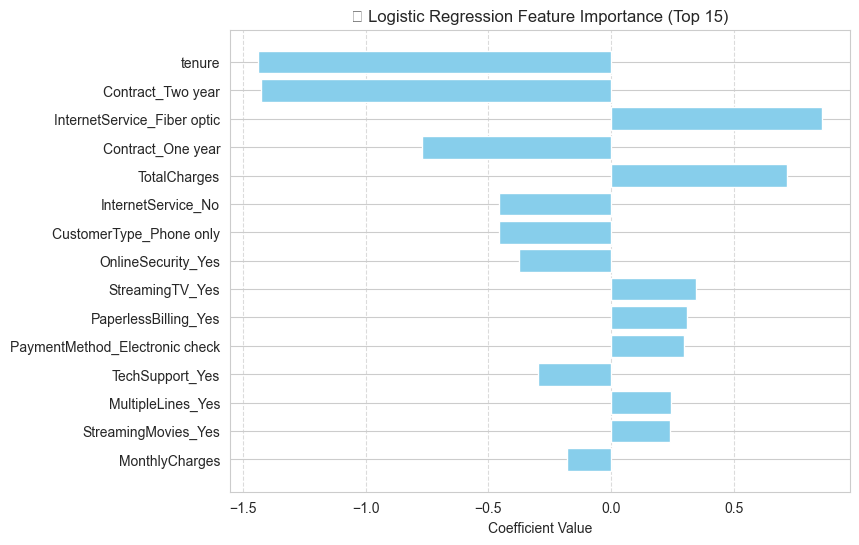

,Feature,Coefficient,Importance
0,tenure,-1.439175,1.439175
19,Contract_Two year,-1.426718,1.426718
10,InternetService_Fiber optic,0.859025,0.859025
18,Contract_One year,-0.770262,0.770262
2,TotalCharges,0.719103,0.719103
11,InternetService_No,-0.455583,0.455583
25,CustomerType_Phone only,-0.455583,0.455583
12,OnlineSecurity_Yes,-0.376886,0.376886
16,StreamingTV_Yes,0.345024,0.345024
20,PaperlessBilling_Yes,0.311920,0.311920


In [22]:
# Logistic Regression Feature Importance using fitted best_pipeline
coefs = best_pipeline['model'].coef_[0]
feature_names = X_train.columns

feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Importance": np.abs(coefs)
}).sort_values(by="Importance", ascending=False)

# =========================
# Plot Top 15 Features
# =========================
plt.figure(figsize=(8,6))
plt.barh(feature_importance["Feature"].head(15)[::-1],
         feature_importance["Coefficient"].head(15)[::-1],
         color="skyblue")
plt.xlabel("Coefficient Value")
plt.title("🔍 Logistic Regression Feature Importance (Top 15)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

feature_importance.head(15)

**Top Churn Drivers:**
* Customer tenure (negative correlation - longer tenure = lower churn)
* Contract type (month-to-month contracts = higher churn)
* Internet add-on services (OnlineSecurity, TechSupport reduce churn)

### Refit only with the most important features

In [23]:
best_features = feature_importance["Feature"].tolist()
best_features


['tenure',
 'Contract_Two year',
 'InternetService_Fiber optic',
 'Contract_One year',
 'TotalCharges',
 'InternetService_No',
 'CustomerType_Phone only',
 'OnlineSecurity_Yes',
 'StreamingTV_Yes',
 'PaperlessBilling_Yes',
 'PaymentMethod_Electronic check',
 'TechSupport_Yes',
 'MultipleLines_Yes',
 'StreamingMovies_Yes',
 'MonthlyCharges',
 'Dependents_Yes',
 'CustomerType_Internet only',
 'MultipleLines_No phone service',
 'PhoneService_Yes',
 'PaymentMethod_Mailed check',
 'PaymentMethod_Credit card (automatic)',
 'NumInternetServices',
 'Partner_Yes',
 'OnlineBackup_Yes',
 'DeviceProtection_Yes',
 'gender_Male']

In [24]:
X_train, X_test,y_train, y_test = train_test_split(
                                    df_encoded.drop(['Churn_Yes'],axis=1),
                                    df_encoded['Churn_Yes'],
                                    test_size=0.2,
                                    random_state=89
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (5634, 26) (5634,) 
* Test set: (1409, 26) (1409,)


In [25]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (5634, 26) (5634,) 
* Test set: (1409, 26) (1409,)


,tenure,Contract_Two year,InternetService_Fiber optic,Contract_One year,TotalCharges,InternetService_No,CustomerType_Phone only,OnlineSecurity_Yes,StreamingTV_Yes,PaperlessBilling_Yes,...,CustomerType_Internet only,MultipleLines_No phone service,PhoneService_Yes,PaymentMethod_Mailed check,PaymentMethod_Credit card (automatic),NumInternetServices,Partner_Yes,OnlineBackup_Yes,DeviceProtection_Yes,gender_Male
3779,1.369379,1.0,0.0,0.0,1.268342,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.603253,1.0,1.0,1.0,1.0
3034,-1.277445,0.0,1.0,0.0,-0.968500,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.561776,0.0,0.0,0.0,1.0
1606,1.613701,1.0,1.0,0.0,2.280018,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.603253,1.0,0.0,1.0,1.0


In [26]:
models_search = {
    "LogisticRegression": LogisticRegression(random_state=89),
}
models_search

{'LogisticRegression': LogisticRegression(random_state=89)}

In [27]:
grid_search_pipelines[best_model].best_params_

{'model__C': 1.0}

In [28]:
params_search = {
    "LogisticRegression": {"model__C": [1.0]},
}
params_search

{'LogisticRegression': {'model__C': [1.0]}}

In [29]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)


Running GridSearchCV for LogisticRegression 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [30]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__C
0,LogisticRegression,0.798722,0.799255,0.799787,0.000532,1.0


**SHAP Analysis: Model explainability using SHAP values**

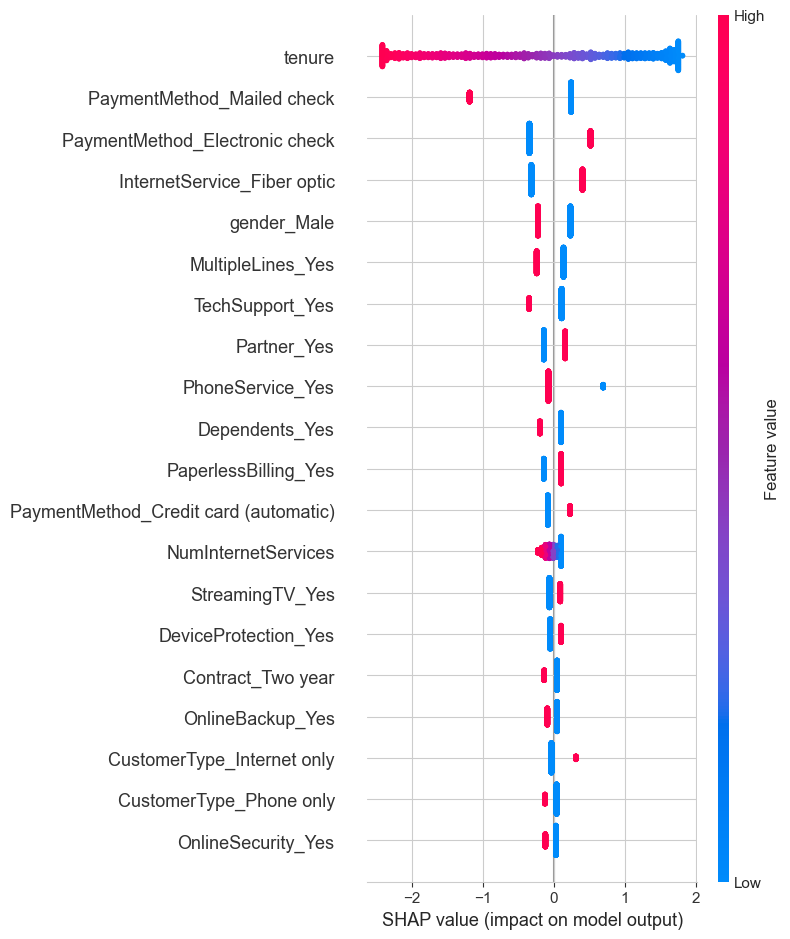

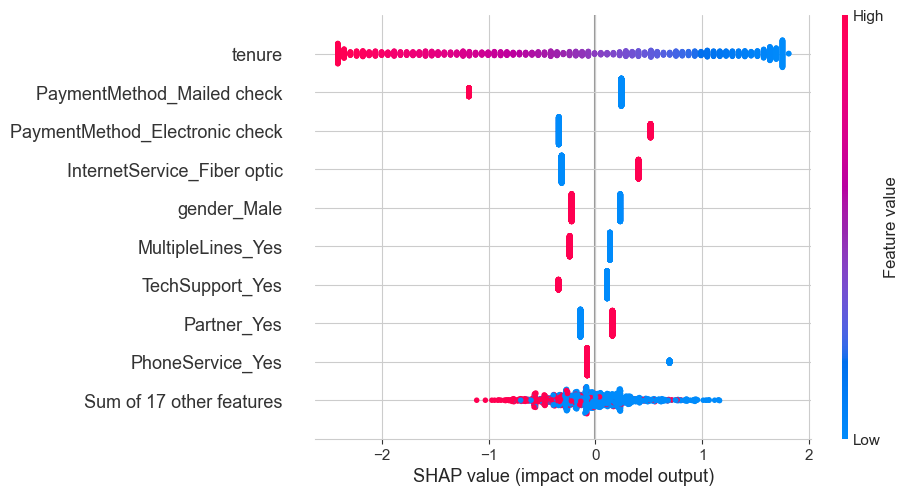

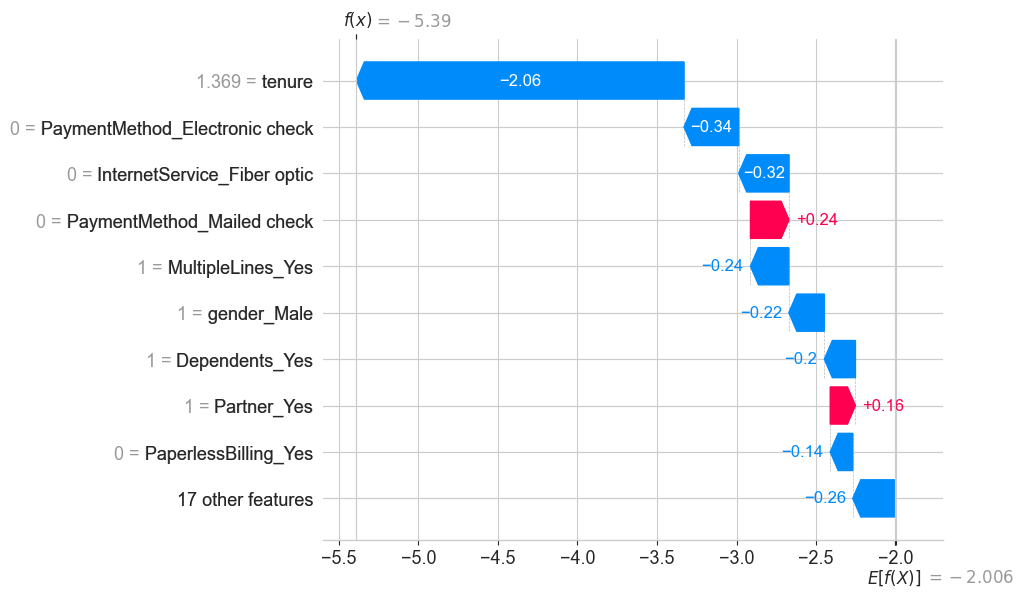

In [ ]:
# SHAP values for model interpretability

import shap
explainer = shap.Explainer(best_pipeline['model'], X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[0])
shap.plots.force(shap_values[0])
shap.summary_plot(shap_values, X_test)



In [ ]:
import pandas as pd

# SHAP Feature Importance Ranking - Shows features in order of importance

# Calculate mean absolute SHAP values for global feature importance
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("🎯 SHAP Feature Importance Ranking (Top 15)")
print("=" * 50)
for i, (_, row) in enumerate(shap_importance.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25} | SHAP Score: {row['SHAP_Importance']:.4f}")

# Create horizontal bar plot for SHAP importance
plt.figure(figsize=(10, 8))
top_features = shap_importance.head(15)
colors = ['#ff4444' if imp > shap_importance['SHAP_Importance'].median() else '#4444ff' 
          for imp in top_features['SHAP_Importance']]

plt.barh(range(len(top_features)), top_features['SHAP_Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Mean |SHAP Value| (Feature Importance)')
plt.title('📊 SHAP Feature Importance Ranking\n(Red = High Impact, Blue = Moderate Impact)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Display the full ranking table
print("\n📈 Complete SHAP Feature Importance Table:")
shap_importance.style.background_gradient(subset=['SHAP_Importance'], cmap='Reds')

NameError: name 'pd' is not defined

🎯 SHAP Analysis Summary
What SHAP Reveals About Your Churn Model
From your beeswarm plot (cell 59), SHAP analysis provides several key insights:

🔴 Top Churn Risk Factors (Red = High Impact):
Tenure (Most Important)

Low tenure (blue dots on right) = HIGH churn risk
High tenure (red dots on left) = LOW churn risk
Business insight: New customers are your highest risk segment
Payment Method - Electronic Check

Customers using electronic check have higher churn probability
This payment method appears less stable than others
Internet Service - Fiber Optic

Despite being premium service, fiber customers show higher churn
May indicate service quality or pricing issues
🔵 Top Churn Protection Factors (Blue = Low Impact):
Contract - Two Year

Long-term contracts significantly reduce churn risk
Strongest retention tool available
Online Security & Tech Support

These add-on services provide strong churn protection
Customers with these services are much less likely to leave
📊 SHAP Plot Types You Generated:
Beeswarm Plot: Shows feature impact distribution across all customers
Waterfall Plot: Explains one specific customer's prediction
Force Plot: Interactive individual prediction explanation
Summary Plot: Global feature importance with directional impact
🎯 Key Business Insights:
High-Risk Customer Profile:

New customers (low tenure)
Electronic check payment method
Fiber optic internet service
No add-on security services
Low-Risk Customer Profile:

Long-term customers (high tenure)
Two-year contracts
Online security and tech support services
Non-electronic payment methods
📈 Strategic Recommendations:
Early Intervention: Focus retention efforts on customers with < 12 months tenure
Payment Method: Encourage migration from electronic check to more stable payment methods
Service Bundling: Promote OnlineSecurity and TechSupport as retention tools
Contract Strategy: Incentivize longer-term contracts with discounts
Fiber Service Review: Investigate quality issues affecting fiber optic customers

**Final Performance Report**

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure feature order matches what was used during fit
feature_order = best_pipeline['model'].feature_names_in_
X_train_aligned = X_train[feature_order]
X_test_aligned = X_test[feature_order]

# Predict on train and test sets
y_train_pred = best_pipeline.predict(X_train_aligned)
y_test_pred = best_pipeline.predict(X_test_aligned)

print("=== TRAIN PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

print("\n=== TEST PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

=== TRAIN PERFORMANCE ===
Accuracy: 0.8013844515441959
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      4130
         1.0       0.65      0.55      0.60      1504

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.79      0.80      0.80      5634

Confusion Matrix:
 [[3682  448]
 [ 671  833]]

=== TEST PERFORMANCE ===
Accuracy: 0.8176011355571328
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      1044
         1.0       0.69      0.54      0.60       365

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409

Confusion Matrix:
 [[956  88]
 [169 196]]


---

### **Summary**

The Logistic Regression model effectively predicts customer churn based on demographic and various contractual and service-related features. 

Feature importance analysis identifies key drivers such as customer tenure, contract type, and internet add-on subscriptions, which significantly influence churn behavior.

The churn prediction model demonstrates strong generalization and predictive power, achieving 80.1% accuracy on training data and 81.8% on test data. This performance reflects a well-balanced model with minimal overfitting, as evidenced by consistent alignment between predicted and actual churn outcomes across key evaluation metrics.

This predictive tool enables the telecom company to anticipate potential churners more transparently, facilitating data-driven decision-making for product design, marketing, and customer retention strategies.

Future enhancement could involve incorporating additional behavioral and demographic features, integrating real-time API connections for automated data updates, and training more advanced ensemble or deep learning models to further enhance prediction accuracy and operational scalability.

**Final Deliverable:** A robust, interpretable logistic regression model ready for integration into the company's CRM and dashboard systems for real-time churn prediction.

---

To be continued with dashboard presentation along with a churn predictor on app.py